 # SAR Target/Object Classification Using Transfert Learning


Mounting Google Drive for Cloud based Processing using GPUs

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import librairies

In [2]:
import sys, os
import collections
import io
import math
import time
import random
from six.moves import urllib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import scipy.misc as im
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from skimage.transform import resize
import sklearn.metrics as sk_metrics
from skimage import data
from IPython.display import clear_output, Image, display, HTML

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout, MaxPool2D, Flatten
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, RMSprop

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow_hub as hubM

Instructions for updating:
non-resource variables are not supported in the long term



## Split data on train test and Explore the images

In [5]:
#main_path_data = "/content/gdrive/My Drive/Colab Notebooks/"
main_path_data = "/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/"

In [6]:
MSTAR_DIR = main_path_data + 'MSTAR-10/'+ 'train/'
os.listdir(MSTAR_DIR)

['BMP2',
 '2S1',
 'BTR70',
 'BTR60',
 'BRDM_2',
 'T62',
 'D7',
 'ZIL131',
 'T72',
 'ZSU_23_4']

In [7]:
def make_train_and_test_sets(input_data_dir):
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(input_data_dir):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [8]:
RANDOM_SEED = 42
TRAIN_FRACTION = 0.8
MSTAR_TRAIN_DIR  = MSTAR_DIR
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets(input_data_dir = MSTAR_TRAIN_DIR)
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))


The dataset has 10 label classes: odict_values(['2S1', 'BMP2', 'BRDM_2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU_23_4'])
There are 2193 training images
there are 553 test images


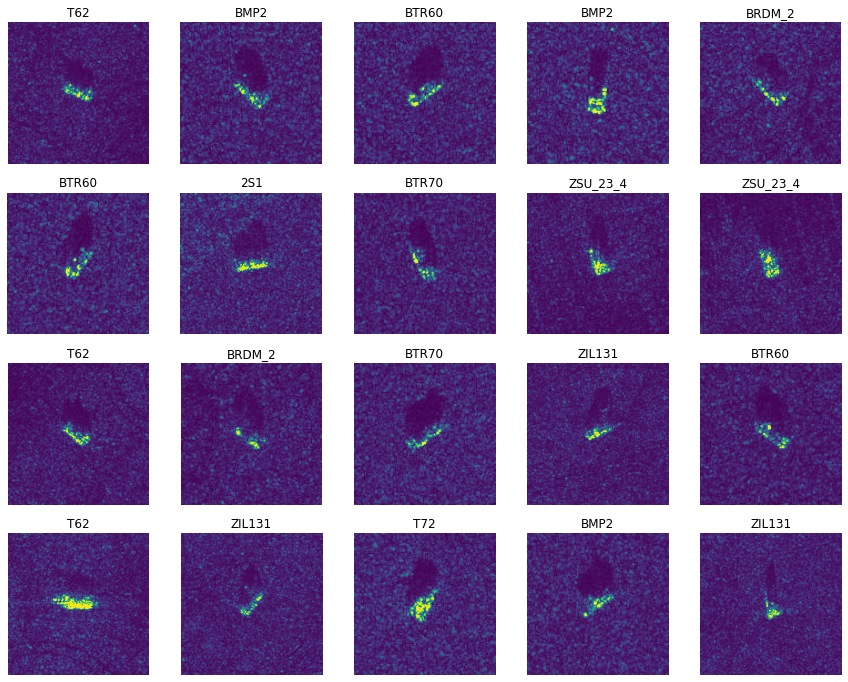

In [9]:
#@title Show some labeled images
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 20 #@param {type: 'integer'}
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

In [15]:
def get_nb_img_color_channel(input_img_path):
  from PIL import Image
  # open image using PIL
  img = Image.open(input_img_path)
  width, height = img.size
  print(f'width, height = {(width, height)}')
  # convert to numpy array
  img = np.array(img)
  # find number of channels
  if img.ndim == 2:
      channels = 1
      print("image has 1 channel")
  else:
      channels = image.shape[-1]
      print("image has", channels, "channels")
  return width, height, channels

In [ ]:
get_nb_img_color_channel(TRAIN_EXAMPLES[0][0])

image has 1 channel


1

# II-Train Using Transfert Learning
Inspired from https://github.com/Accioy/sar-10-classification/blob/master/nn.py

# II-1-data preparation and augmentation

In [16]:
def get_nb_images_of_train_val(input_folder):
  count = 0
  for i in os.listdir(input_folder):
    for j in i:
      nb_img = len(os.listdir(input_folder + '/' + i))
    count += nb_img
  return count

def compute_nb_paramters_per_layer(kernel_size, stride, nb_filter):
  return (kernel_size[0]*kernel_size[1]*stride+1)*nb_filter

In [17]:
input_image_size = [224,224]
#input_image_size = [224,224]

batch_size = 64
#color_mode = 'grayscale'
class_mode = 'categorical'

In [18]:
directory_data = os.path.join(main_path_data,'MSTAR-10','train')
#directory_val = os.path.join(main_path_data,'MSTAR-10','test')

print(directory_data)


/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/train


In [19]:
# add data augmentation only for the training set 
pct_val_set = 0.2

train_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1,
      fill_mode='constant',
      cval=0.0,
      horizontal_flip=True,
      vertical_flip=True,
      rescale=1./255,
      validation_split=pct_val_set,
  )

val_generator = ImageDataGenerator(rescale=1./255, validation_split=pct_val_set)

print('Creation of train genarator include data augmentation ')

#val_generator = ImageDataGenerator(rescale=1./255)
print('Creation of val genarator without data augmentation (only rescale the image to normalize them) ')

Creation of train genarator include data augmentation 
Creation of val genarator without data augmentation (only rescale the image to normalize them) 


In [20]:
# preparation of data train and data val before feed them to the netwrok architecture model
print('data_training'.upper())
data_training = train_generator.flow_from_directory(directory=directory_data,
                                                 target_size=input_image_size,
                                                 class_mode=class_mode ,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 subset = 'training')

print('data_validation'.upper())
data_validation = val_generator.flow_from_directory(directory=directory_data,
                                                   target_size=input_image_size,
                                                   class_mode=class_mode,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                    subset = 'validation')

DATA_TRAINING
Found 2203 images belonging to 10 classes.
DATA_VALIDATION
Found 543 images belonging to 10 classes.


In [21]:
for i in range(10):
  input_img_path = TRAIN_EXAMPLES[i][0]
  print(input_img_path)
  get_nb_img_color_channel(input_img_path)

/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/train/T62/hb20011.jpeg
width, height = (172, 173)
image has 1 channel
/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/train/BMP2/hb03864.jpeg
width, height = (128, 128)
image has 1 channel
/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/train/BTR60/hb03827.jpeg
width, height = (128, 128)
image has 1 channel
/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/train/BMP2/hb03932.jpeg
width, height = (128, 128)
image has 1 channel
/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/train/BRDM_2/hb19949.jpeg
width, height = (128, 129)
image has 1 channel
/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/train/BTR60/hb03942.jpeg
width, height = (128, 128)
ima

In [ ]:
# print index and name of training classes 
data_training.class_indices

{'2S1': 0,
 'BMP2': 1,
 'BRDM_2': 2,
 'BTR60': 3,
 'BTR70': 4,
 'D7': 5,
 'T62': 6,
 'T72': 7,
 'ZIL131': 8,
 'ZSU_23_4': 9}

In [ ]:
# print index and name of validation classes 
data_validation.class_indices

{'2S1': 0,
 'BMP2': 1,
 'BRDM_2': 2,
 'BTR60': 3,
 'BTR70': 4,
 'D7': 5,
 'T62': 6,
 'T72': 7,
 'ZIL131': 8,
 'ZSU_23_4': 9}

**Get the train and val size and Define the number of step per epoch**

In [ ]:
'''
train_size = get_nb_images_of_train_val(directory_train)
val_size = get_nb_images_of_train_val(directory_val)
print(f'Nb TRAIN images = {train_size} \nNb VAL images = {val_size}')
print(f'pct of TRAIN images = {np.round(train_size/(train_size+val_size),2)} \npct of VAL images = {np.round(val_size/(train_size+val_size),2)}')
step_train_per_epoch = train_size//batch_size
step_val_per_epoch = val_size//batch_size
print(f'Nb Train steps per epoch = {step_train_per_epoch}\nNb Val steps per epoch = {step_val_per_epoch}')
'''

Nb TRAIN images = 2746 
Nb VAL images = 2425
pct of TRAIN images = 0.53 
pct of VAL images = 0.47
Nb Train steps per epoch = 42
Nb Val steps per epoch = 37


In [46]:
train_size0 = get_nb_images_of_train_val(directory_data)
train_size = (1-pct_val_set)*train_size0
val_size = (pct_val_set)*train_size0

step_train_per_epoch = train_size//batch_size
step_val_per_epoch = val_size//batch_size

print(f'Nb Train steps per epoch = {step_train_per_epoch}\nNb Val steps per epoch = {step_val_per_epoch}')

#print(train_size)


Nb Train steps per epoch = 34.0
Nb Val steps per epoch = 8.0


# II-2-Build architecture by transfert learning from exiting architecture 

**A-Fine tunning using VGG 16**

tf.keras.applications.InceptionV3(
                                  include_top=True,
                                  weights="imagenet",
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation="softmax",
                              )


In [47]:
from keras import optimizers

In [48]:
#vgg16_model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', 
#    input_shape=(input_image_size[0],input_image_size[1],3), pooling='max')

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
    input_shape=(input_image_size[0],input_image_size[1],3))

vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Convert from Keras engine model to a sequential model for ease of use

In [49]:

#x=vgg19_model.layers[-4].output
x=vgg19_model.output
x=Flatten()(x)
x=Dense(1024,activation = 'relu')(x)
#x=Dropout(0.5)(x)
#x=Dense(4096,activation = 'relu')(x)
#x=Dropout(0.5)(x)
predict=Dense(10, activation = 'softmax')(x)

In [50]:
model=Model(inputs=vgg19_model.input, outputs=predict)
adam=optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['categorical_accuracy'])

print('#of layers for VGG16 model : ',len(vgg19_model.layers))
print('#of layers for custom model(VGG16+Dense2048+predictSoftmax10): ',len(model.layers))
model.summary()

#of layers for VGG16 model :  22
#of layers for custom model(VGG16+Dense2048+predictSoftmax10):  25
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________

In [ ]:
from keras.utils import  plot_model
#plot_model(vgg16_model)

In [51]:
sys.path.append(main_path_data + 'data_prep')

In [52]:
import datetime
date_object = datetime.date.today()
date_object = str(date_object).replace('-','_')


In [56]:
type_model = 'img224'
path_to_save_model = main_path_data + f'trained_models/{date_object}'
model_path = path_to_save_model  + f'/mstar_vgg19_{date_object}_{type_model}_'+'{epoch:02d}-{val_acc:.2f}.hdf5'
model_path

'/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/trained_models/2021_04_25/mstar_vgg19_2021_04_25_img224_{epoch:02d}-{val_acc:.2f}.hdf5'

**Freeze layers**

In [31]:
def show_trainble_layers(model_name):
  for i, layer in enumerate(model_name.layers):
    print(i,layer.name,layer.trainable)
    

for layer in model.layers[:-2]:
    layer.trainable = False
show_trainble_layers(model_name=model)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False
22 flatten_1 False
23 dense_2 True
24 dense_3 True


# II-3-Launch training: 

*   Define the hyperparameters of training : lr, optimizer

1.   compile the model
2.   fit the model

In [57]:
lr = 1e-3
decacy = 0
nb_epochs = 20

In [58]:
# model callbeck list and save option 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001,verbose=1)

# keep the best checkpoint
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, mode='auto',save_best_only=True) 

# stop training when the accuracy does not continue improvement
early_stopping_monitor = EarlyStopping(monitor='val_acc',min_delta=0,patience=5,verbose=0, mode='auto')

callbacks_list = [checkpoint, reduce_lr]

In [59]:
# define the optimizer
#adam=optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam = Adam(lr=lr, decay=decacy) 
rmsprop = RMSprop(lr=lr, decay=decacy)

In [60]:

# compile the model
#model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['categorical_accuracy'])
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [ ]:
# Launch training 
history = model.fit_generator(generator=data_training,
                    validation_data=data_validation,
                    use_multiprocessing=False,
                    steps_per_epoch=step_train_per_epoch,
                    epochs=nb_epochs,
                    validation_steps=step_val_per_epoch,
                    verbose=1,
                    callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/20


In [ ]:
history.history.keys()

In [ ]:
print('max acc',np.max(history.history['acc']))
print('max val_acc',np.max(history.history['val_acc']))

print('max loss',np.max(history.history['loss']))
print('max val_loss',np.max(history.history['val_loss']))


model.fit_generator(generator=data_train,epochs=100,
    validation_data=data_validation)
model.save('mstar10.h5')

# **III-Aanlysis of model performances**

**Plot historay training**

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['acc: train', 'acc: val'], loc='upper left', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Make prediction of all validation set**

In [ ]:
selected_model_name = 'mstar_vgg16_2021_04_24_19-0.23.hdf5'
path_selected_model = f'{path_to_save_model}/{selected_model_name}' 
print(f'Prediction using inference model: {path_selected_model}')

Prediction using inference model: /content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/trained_models/2021_04_24/mstar_vgg16_2021_04_24_19-0.23.hdf5


In [ ]:
inference_model = load_model(path_selected_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
inference_model.layers[0].input_shape

[(None, 128, 128, 3)]

In [ ]:
# generate the test set images
test_generator = ImageDataGenerator(rescale=1./255)
data_test = test_generator.flow_from_directory(directory=directory_val,
    target_size=[128,128],class_mode='categorical',
    batch_size=32,shuffle=False)
print(data_test.class_indices)


#color_mode='grayscale'

Found 2425 images belonging to 10 classes.
{'2S1': 0, 'BMP2': 1, 'BRDM_2': 2, 'BTR60': 3, 'BTR70': 4, 'D7': 5, 'T62': 6, 'T72': 7, 'ZIL131': 8, 'ZSU_23_4': 9}


In [ ]:
data_test[0][0].shape

NameError: ignored

In [ ]:
import time
start = time.time()
evaluation = inference_model.evaluate_generator(data_test)

end = time.time()
print(f"Runtime of the program is {end - start}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
print(evaluation)

[2.0998638303656327, 0.22639175]


In [ ]:
os.listdir(directory_val)

['BTR70',
 'BTR60',
 'BMP2',
 '2S1',
 'BRDM_2',
 'D7',
 'T62',
 'T72',
 'ZIL131',
 'ZSU_23_4']

In [ ]:
picturePath = directory_val + '/'+ 'BTR60' + '/'
os.listdir(picturePath)[0]
picturePath = picturePath + os.listdir(picturePath)[20]
picturePath

'/content/gdrive/My Drive/career/ML-DL/courses-ML-DL/Projects/Helmi/Image_DL_Project-main/MSTAR-10/test/BTR60/hb03356.jpeg'

In [ ]:
img_width = 128
img_height = 128

In [ ]:
index_class_val_set = data_validation.class_indices
index_class_val_set

{'2S1': 0,
 'BMP2': 1,
 'BRDM_2': 2,
 'BTR60': 3,
 'BTR70': 4,
 'D7': 5,
 'T62': 6,
 'T72': 7,
 'ZIL131': 8,
 'ZSU_23_4': 9}

In [ ]:
image_path = picturePath
img = image.load_img(image_path, target_size=(img_width, img_height), color_mode="grayscale")
plt.imshow(img, cmap='gray')
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = inference_model.predict(img)
plt.title(result)
plt.show()

NameError: ignored

**Plot Confusion matrix**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Confution Matrix and Classification Report
Y_pred = inference_model.predict_generator(data_test)

In [ ]:
len(Y_pred)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(data_test.classes, y_pred)
print(cm)

In [ ]:
target_names = list(index_class_val_set.keys())


In [ ]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
make_confusion_matrix(cm,
                          group_names=None,
                          categories=target_names,
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=(12,10),
                          cmap='Blues',
                          title=None)

In [ ]:
print('Classification Report')
print(classification_report(data_validation.classes, y_pred, target_names=target_names))